# **1 Introduction**

First we need to mount the drive and `cd` to the correct directory.

In [ ]:
# Mount drive
from google.colab import drive; drive.mount('/content/drive')

# CD to current directroy
%cd /content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Notebooks/Feed Forward Neural Nets

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Notebooks/Feed Forward Neural Nets


## **1.1 Notebook goal**

We are going to construct at vanilla feed forward network (FFN). A lot of techniques can be used, but since proprocessing, tuning and training is not the goal of the thesis, we keep this fairly breif and simplictic.


High level notebook structure:
1.  Import data and prepare related functions.
2.  Create rough baseline model.
3.  Perform model search to find a model that represents this architecture well.
4.  Fully train best model found.
5.  Evaluate and save fully trained model.


3 is an important step which can be analysed thoroughly in order to extract the most signal from data. **However**, this is not our research topic, so we use the following approach (high level description, see relevant section for further).
1. Set most parameters (hyperparameters, training parameters and architecture parameters to defaults).
2. From pior knowledge define ~5 parameters that will be tuned (most important parameters).
3. Conduct a 60 trial search over defined space (using median pruner to ease computational costs whilst preserving enough models, and RandomSampler).
4. Analyse parameter frequency in best performing trials, and freeze most _dominant_ parameters.
5. Repeat 3-4 until no clear parameter-pattern can be observed from best performing trials.
6. Tune basis model (derrived from 3-5) with pruning (again to ease computational costs). If more than one trial survives the the model confidence set is used to identify the _best_ model.

# **2 Imports**

In [ ]:
# Package import
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

# Optuna download and import
!pip install -q optuna==3.4.0
!pip install -q optuna-integration
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 2.1 MB/s eta 0:00:00


In [ ]:
# Load data and sort by eom
securities_data = pd.read_parquet('../Data/handoffs/data_stock_returns_final.parquet')
securities_data = securities_data.sort_values('eom')


# List of features
features = [
    feat for feat in securities_data.columns
    if feat not in ['eom', 'id', 'ret_exc_lead1m']
]


# Time-based split
months = sorted(securities_data['eom'].unique())
n = len(months)
splits = [int(n * 0.7), int(n * 0.85)]

month_bins = [
    months[:splits[0]],             # Train
    months[splits[0]:splits[1]],    # Validation
    months[splits[1]:],             # Test
]


# Create datasets
datasets = [
    securities_data[securities_data['eom'].isin(m)] for m in month_bins
]


# Create datasets
X_train, y_train = datasets[0][features].values.astype('float32'), datasets[0]['ret_exc_lead1m'].values.astype('float32')
X_val, y_val     = datasets[1][features].values.astype('float32'), datasets[1]['ret_exc_lead1m'].values.astype('float32')
X_test, y_test   = datasets[2][features].values.astype('float32'), datasets[2]['ret_exc_lead1m'].values.astype('float32')

Remove unnessecary variables

In [ ]:
del securities_data, datasets, features

# **3 Baseline model**

A quick baseline model is created and trained.

In [ ]:
# Baseline model
ffn_baseline = tf.keras.Sequential([
    # Input layer

    tf.keras.layers.Input(shape=(X_test.shape[1], )),

    # 1'st hidden layer
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L2()),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(rate=0.25),

    # 2'nd hidden layer
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.L2()),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(rate=0.25),

    # 3'nd hidden layer
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.L2()),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(rate=0.25),

    # Output layer
    tf.keras.layers.Dense(1, activation='linear')
])

The model is complied.

In [ ]:
ffn_baseline.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mse',
    metrics=['mse', 'mae']
)

The model is now trained with early stopping to avoid overfitting and learning noise.


In [ ]:
# Create early stopping callback
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=10,
    restore_best_weights=True
)


# Train model
ffn_baseline_history = ffn_baseline.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=128,
    epochs=60,
    callbacks=[earlystop_cb],
    verbose=1
)

Epoch 1/60
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 1.0354 - mae: 0.2913 - mse: 0.2215 - val_loss: 0.0374 - val_mae: 0.0684 - val_mse: 0.0096
Epoch 2/60
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0323 - mae: 0.0888 - mse: 0.0178 - val_loss: 0.0107 - val_mae: 0.0678 - val_mse: 0.0095
Epoch 3/60
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0183 - mae: 0.0871 - mse: 0.0176 - val_loss: 0.0096 - val_mae: 0.0679 - val_mse: 0.0095
Epoch 4/60
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0176 - mae: 0.0866 - mse: 0.0176 - val_loss: 0.0097 - val_mae: 0.0693 - val_mse: 0.0097
Epoch 5/60
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0170 - mae: 0.0864 - mse: 0.0170 - val_loss: 0.0097 - val_mae: 0.0690 - val_mse: 0.0097
Epoch 6/60
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0176 - mae: 0.0867 - mse: 0.0176 - val_loss: 0.0095 - val_mae: 0.0677 - val_mse: 0.0095
Epoch 7/60
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0175 - mae: 0.0863 - ms

We save the baseline model so we can use it for furture evaluation.

In [ ]:
ffn_baseline.save('models studies/baseline_model_fnn.keras')

## **3.1 Evaluating baseline model**

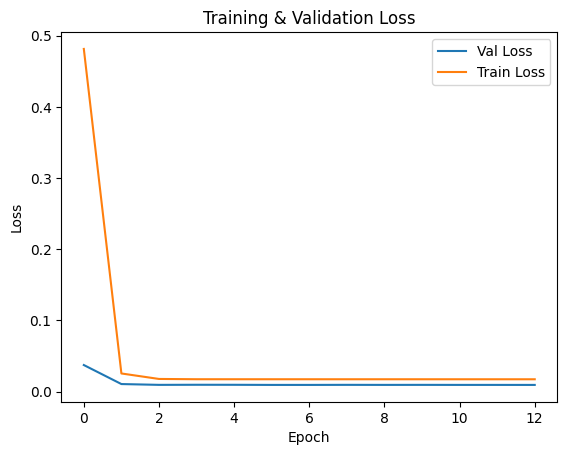

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ffn_baseline_history.history['val_loss'], label='Val Loss')
plt.plot(ffn_baseline_history.history['loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

# **4 Model Search**

We will tune the following parameters
1. Number of units
2. Number of hidden layers.
3. Optimizer used (adam or sgd)
4. Batch size
5. Learning rate
6. L2 regulizer (and factor if picked)

In addition the models will always use
- ReLU activation functions (standard activation function).
- Layer normalisation.
- Dropout rate (prevents co-adaptation of neurons).


Instead of creating a new function every time i will make a function that allows me to iteratively freeze variables.

## **4.1 First search**

### **4.1.1 Functions**

Function for the first model search.

- Uses optuna framework.
- Sampling: Uses the TPE sampler with default values to search HP space intelligently.
- Pruner: Uses median pruner to reduce computational costs whilst keeping enough models to evaluate default parameters. (With TPESampler it is expected that more than 50% of trials survive pruning, since they keep on imporving during search, which is good for this approach).

In [ ]:
# Global variables
SEED          = 42
N_TRAILS      = 60
MAX_EPOCHS    = 30
INPUT_SHAPE   = (X_train.shape[1],)
OUTPUT_SHAPE  = 1

NameError: name 'X_train' is not defined

In [ ]:
STORAGE_URI   = 'sqlite:///models studies/first_search.db'

Function below build the models whilst sampling architecture parameters from specified searchspace.

In [ ]:
def create_model(trial: optuna.Trial):
  # Units and layers
  n_units = trial.suggest_categorical('n_units', [32, 64, 128, 256])
  n_layers = trial.suggest_categorical('n_layers', [2, 3, 4, 5, 6])

  # Regularizer
  bool_l2 = trial.suggest_categorical('bool_l2', [True, False])
  l2_fac = trial.suggest_float('l2_fac', 1e-4, 1e-2, log=True) if bool_l2 else None
  l2_reg = tf.keras.regularizers.L2(l2_fac) if bool_l2 else None

  # Create model
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=INPUT_SHAPE))

  for _ in range(n_layers):
    model.add(tf.keras.layers.Dense(n_units, activation='relu', kernel_regularizer=l2_reg))
    model.add(tf.keras.layers.LayerNormalization())
    model.add(tf.keras.layers.Dropout(rate=0.25))

  model.add(tf.keras.layers.Dense(OUTPUT_SHAPE, activation='linear', kernel_regularizer=l2_reg))

  return model

Function below return the validation loss, which is used by pruner to stop models that project high val_loss early on (assume monotonic decrease in validation loss).

In [ ]:
def objective(trial: optuna.Trial):
  # Learning related HP's
  bs = trial.suggest_categorical('bs', [32, 64, 128, 256])
  lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
  opt = trial.suggest_categorical('opt', ['adam', 'sgd'])
  if opt == 'sgd':
    optimizer = tf.keras.optimizers.SGD(lr)
  if opt == 'adam':
    optimizer = tf.keras.optimizers.Adam(lr)

  # Retrive and compile models
  model = create_model(trial)
  model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mae'])

  # Callbacks
  earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=5,
    restore_best_weights=True
  )
  pruning_cb = optuna.integration.KerasPruningCallback(trial, "val_loss")

  # Train model
  model.fit(
      X_train, y_train,
      validation_data=(X_val, y_val),
      epochs = MAX_EPOCHS,
      batch_size=bs,
      callbacks=[pruning_cb, earlystop_cb],
      verbose=0
  )

  return model.evaluate(X_val, y_val, verbose=0)[0]

### **4.1.2 Study**

The study is run below over 60 trials (ensure that we sample at least one model froem the top 5% of all models, if we were to sample randomly).

In [ ]:
sampler = optuna.samplers.TPESampler(seed=SEED)
pruner = optuna.pruners.MedianPruner(
    n_startup_trials=10,
    n_warmup_steps=3,
    interval_steps=1,
)

first_search = optuna.create_study(
    direction='minimize',
    study_name='first_search',
    sampler=sampler,
    pruner=pruner,
    storage=STORAGE_URI,
    load_if_exists=True
)

first_search.optimize(objective, n_trials=N_TRAILS)

[I 2025-05-07 09:40:18,105] A new study created in RDB with name: first_search
[I 2025-05-07 09:41:20,638] Trial 0 finished with value: 0.009518316015601158 and parameters: {'bs': 64, 'lr': 2.9380279387035334e-05, 'opt': 'adam', 'n_units': 32, 'n_layers': 2, 'bool_l2': False}. Best is trial 0 with value: 0.009518316015601158.
[I 2025-05-07 09:43:13,014] Trial 1 finished with value: 0.09776565432548523 and parameters: {'bs': 128, 'lr': 7.52374288453485e-05, 'opt': 'sgd', 'n_units': 32, 'n_layers': 6, 'bool_l2': True, 'l2_fac': 0.0004066563313514797}. Best is trial 0 with value: 0.009518316015601158.
[I 2025-05-07 09:46:24,324] Trial 2 finished with value: 1.0824809074401855 and parameters: {'bs': 64, 'lr': 0.0003058656666978527, 'opt': 'sgd', 'n_units': 64, 'n_layers': 4, 'bool_l2': True, 'l2_fac': 0.0069782812651260325}. Best is trial 0 with value: 0.009518316015601158.
[I 2025-05-07 09:47:31,936] Trial 3 finished with value: 0.011451343074440956 and parameters: {'bs': 256, 'lr': 0.000

If the search already has been run the code below loads it more directly.

In [ ]:
first_search = optuna.load_study(
    study_name='first_search',
    storage=STORAGE_URI
)

### **4.1.3 Parameter Frequency**

We now evaluate the top 20% best performing models and look at patterns in their parameters.

In [ ]:
# Get all complete trials and sort
first_search_df = first_search.trials_dataframe()
first_search_df = first_search_df[first_search_df['state'] == 'COMPLETE']
first_search_df = first_search_df.drop(columns=['datetime_start', 'datetime_complete', 'duration', 'state'])
first_search_df = first_search_df.sort_values(by='value')

# Get best trials
first_search_best_trials = first_search_df.head(int(0.2 * len(first_search_df)))
first_search_best_trials

,number,value,params_bool_l2,params_bs,params_l2_fac,params_lr,params_n_layers,params_n_units,params_opt
42,42,0.009514,False,64,NaN,0.000025,2,256,adam
43,43,0.009514,False,64,NaN,0.000032,2,256,adam
18,18,0.009514,False,64,NaN,0.000058,2,256,adam
41,41,0.009516,False,64,NaN,0.000024,2,256,adam
19,19,0.009517,False,64,NaN,0.000055,3,256,adam
0,0,0.009518,False,64,NaN,0.000029,2,32,adam
26,26,0.009519,False,64,NaN,0.000020,2,256,adam
17,17,0.009520,False,64,NaN,0.000023,2,256,adam


We can see several patterns. Firstly we see that no models use L2 regularization. We thus deem that dropout and layer normalisation is enough and using L2 regularization is overkill.

We therefore freeze L2 regularization to `False` and move on to the second search.

## **4.2 Second search**

In order to encurage the TPESampler to explore more of the surrogate distribution, making the sampling less myopic. This is done changing the following:
- `n_start_up`: How many trials we run before the TPE sampler kicks in. We set this to 20 (standard 10).
- `n_ei_candidate`: how many samples we draw from the surrogate model. We set this to 48 (standard 24).

### **4.2.1 Functions**

In [ ]:
STORAGE_URI   = 'sqlite:///models studies/second_search.db'

Function below build the models whilst sampling architecture parameters from specified searchspace.

In [ ]:
def create_model(trial: optuna.Trial):
  # Units and layers
  n_units = trial.suggest_categorical('n_units', [32, 64, 128, 256])
  n_layers = trial.suggest_categorical('n_layers', [2, 3, 4, 5, 6])

  # Create model
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=INPUT_SHAPE))

  for _ in range(n_layers):
    model.add(tf.keras.layers.Dense(n_units, activation='relu'))
    model.add(tf.keras.layers.LayerNormalization())
    model.add(tf.keras.layers.Dropout(rate=0.25))

  model.add(tf.keras.layers.Dense(OUTPUT_SHAPE, activation='linear'))

  return model

Function below return the validation loss, which is used by pruner to stop models that project high val_loss early on (assume monotonic decrease in validation loss).

In [ ]:
def objective(trial: optuna.Trial):
  # Learning related HP's
  bs = trial.suggest_categorical('bs', [32, 64, 128, 256])
  lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
  opt = trial.suggest_categorical('opt', ['adam', 'sgd'])
  if opt == 'sgd':
    optimizer = tf.keras.optimizers.SGD(lr)
  if opt == 'adam':
    optimizer = tf.keras.optimizers.Adam(lr)

  # Retrive and compile models
  model = create_model(trial)
  model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mae'])

  # Callbacks
  earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=5,
    restore_best_weights=True
  )
  pruning_cb = optuna.integration.KerasPruningCallback(trial, "val_loss")

  # Train model
  model.fit(
      X_train, y_train,
      validation_data=(X_val, y_val),
      epochs = MAX_EPOCHS,
      batch_size=bs,
      callbacks=[pruning_cb, earlystop_cb],
      verbose=0
  )

  return model.evaluate(X_val, y_val, verbose=0)[0]

### **4.2.2 Study**

The study is run below over 60 trials (ensure that we sample at least one model froem the top 5% of all models, if we were to sample randomly).

In [ ]:
sampler = optuna.samplers.TPESampler(n_startup_trials=20, n_ei_candidates=48)
pruner = optuna.pruners.MedianPruner(
    n_startup_trials=10,
    n_warmup_steps=3,
    interval_steps=1,
)

second_search = optuna.create_study(
    direction='minimize',
    study_name='second_search',
    sampler=sampler,
    pruner=pruner,
    storage=STORAGE_URI,
    load_if_exists=True
)

second_search.optimize(objective, n_trials=N_TRAILS)

[I 2025-05-07 15:18:34,459] A new study created in RDB with name: second_search
[I 2025-05-07 15:19:22,541] Trial 0 finished with value: 0.00954400934278965 and parameters: {'bs': 128, 'lr': 0.0013592967979771536, 'opt': 'sgd', 'n_units': 256, 'n_layers': 4}. Best is trial 0 with value: 0.00954400934278965.
[I 2025-05-07 15:20:49,518] Trial 1 finished with value: 0.009532688185572624 and parameters: {'bs': 64, 'lr': 8.529386215017701e-05, 'opt': 'adam', 'n_units': 128, 'n_layers': 6}. Best is trial 1 with value: 0.009532688185572624.
[I 2025-05-07 15:21:43,746] Trial 2 finished with value: 0.00956322904676199 and parameters: {'bs': 128, 'lr': 8.330487148785682e-05, 'opt': 'adam', 'n_units': 32, 'n_layers': 6}. Best is trial 1 with value: 0.009532688185572624.
[I 2025-05-07 15:22:33,316] Trial 3 finished with value: 0.009523850865662098 and parameters: {'bs': 128, 'lr': 2.7505484201847053e-05, 'opt': 'adam', 'n_units': 128, 'n_layers': 3}. Best is trial 3 with value: 0.00952385086566209

If study already run, then just load again.

In [ ]:
!pip install -q optuna==3.4.0
!pip install -q optuna-integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 6.1 MB/s eta 0:00:00


In [ ]:
import optuna

second_search = optuna.load_study(
    study_name='second_search',
    storage=STORAGE_URI
)

### **4.2.3 Parameter Frequency**

We now evaluate the top 20% best performing models and look at patterns in their parameters.

In [ ]:
# Get all complete trials and sort
second_search_df = second_search.trials_dataframe()
second_search_df = second_search_df[second_search_df['state'] == 'COMPLETE']
second_search_df = second_search_df.drop(columns=['datetime_start', 'datetime_complete', 'duration', 'state'])
second_search_df = second_search_df.sort_values(by='value')

# Get best trials
second_search_best_trials = second_search_df.head(int(0.2 * len(second_search_df)))
second_search_best_trials

,number,value,params_bs,params_lr,params_n_layers,params_n_units,params_opt
55,55,0.009512,128,0.002207,2,256,adam
40,40,0.009514,32,0.001748,3,256,adam
58,58,0.009515,128,0.001098,2,256,adam
9,9,0.009515,256,0.003460,3,256,adam
22,22,0.009516,256,0.000250,4,64,adam
57,57,0.009516,128,0.002129,2,256,adam
24,24,0.009516,256,0.001628,5,256,adam
5,5,0.009516,128,0.005701,5,128,adam
33,33,0.009516,256,0.002939,6,256,adam
14,14,0.009516,128,0.000152,4,64,adam


It is clear that the best optimizer in this case is the adam optimizer. Therefore, the optimizer is frozen to be the adam optimizer.

## **4.3 Third search**

We continue using the parameters in the TPESampler described before:
- `n_start_up`: How many trials we run before the TPE sampler kicks in. We set this to 20 (standard 10).
- `n_ei_candidate`: how many samples we draw from the surrogate model. We set this to 48 (standard 24).

### **4.3.1 Functions**

In [ ]:
# Global variables
SEED          = 42
N_TRAILS      = 60
MAX_EPOCHS    = 30
INPUT_SHAPE   = (X_train.shape[1],)
OUTPUT_SHAPE  = 1

NameError: name 'X_train' is not defined

In [ ]:
# Storage for third search
STORAGE_URI = 'sqlite:///models studies/third_search.db'

Function below build the models whilst sampling architecture parameters from specified searchspace.

In [ ]:
!pip install -q optuna==3.4.0
!pip install -q optuna-integration
import tensorflow as tf
import optuna

def create_model(trial: optuna.Trial):
  # Units and layers
  n_units = trial.suggest_categorical('n_units', [32, 64, 128, 256])
  n_layers = trial.suggest_categorical('n_layers', [2, 3, 4, 5, 6])

  # Create model
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=INPUT_SHAPE))

  for _ in range(n_layers):
    model.add(tf.keras.layers.Dense(n_units, activation='relu'))
    model.add(tf.keras.layers.LayerNormalization())
    model.add(tf.keras.layers.Dropout(rate=0.25))

  model.add(tf.keras.layers.Dense(OUTPUT_SHAPE, activation='linear'))

  return model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 10.4 MB/s eta 0:00:00


Function below return the validation loss, which is used by pruner to stop models that project high val_loss early on (assume monotonic decrease in validation loss).

In [ ]:
def objective(trial: optuna.Trial):
  # Learning related HP's
  bs = trial.suggest_categorical('bs', [32, 64, 128, 256])
  lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)

  # Retrive and compile models
  model = create_model(trial)
  model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse', metrics=['mse', 'mae'])

  # Callbacks
  earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=5,
    restore_best_weights=True
  )
  pruning_cb = optuna.integration.KerasPruningCallback(trial, "val_loss")

  # Train model
  model.fit(
      X_train, y_train,
      validation_data=(X_val, y_val),
      epochs = MAX_EPOCHS,
      batch_size=bs,
      callbacks=[pruning_cb, earlystop_cb],
      verbose=0
  )

  return model.evaluate(X_val, y_val, verbose=0)[0]

### **4.3.2 Study**

The study is run below over 60 trials (ensure that we sample at least one model froem the top 5% of all models, if we were to sample randomly).

In [ ]:
sampler = optuna.samplers.TPESampler(n_startup_trials=20, n_ei_candidates=48)
pruner = optuna.pruners.MedianPruner(
    n_startup_trials=10,
    n_warmup_steps=3,
    interval_steps=1,
)

third_search = optuna.create_study(
    direction='minimize',
    study_name='third_search',
    sampler=sampler,
    pruner=pruner,
    storage=STORAGE_URI,
    load_if_exists=True
)

third_search.optimize(objective, n_trials=N_TRAILS)

[I 2025-05-07 16:48:09,470] Using an existing study with name 'third_search' instead of creating a new one.
[I 2025-05-07 16:48:42,916] Trial 0 finished with value: 0.009623339399695396 and parameters: {'bs': 128, 'lr': 0.000996684233835353, 'n_units': 64, 'n_layers': 3}. Best is trial 0 with value: 0.009623339399695396.
[I 2025-05-07 16:49:04,572] Trial 1 finished with value: 0.009524617344141006 and parameters: {'bs': 256, 'lr': 0.0006411148596892109, 'n_units': 256, 'n_layers': 3}. Best is trial 1 with value: 0.009524617344141006.
[I 2025-05-07 16:51:01,819] Trial 2 finished with value: 0.009515541605651379 and parameters: {'bs': 32, 'lr': 1.942318589802961e-05, 'n_units': 128, 'n_layers': 2}. Best is trial 2 with value: 0.009515541605651379.
[I 2025-05-07 16:51:23,148] Trial 3 finished with value: 0.009517502970993519 and parameters: {'bs': 256, 'lr': 0.0012010877839991043, 'n_units': 32, 'n_layers': 3}. Best is trial 2 with value: 0.009515541605651379.
[I 2025-05-07 16:52:09,594] 

If study already run, then just load again.

In [ ]:
third_search = optuna.load_study(
    study_name='third_search',
    storage=STORAGE_URI
)

### **4.3.3 Parameter frequency**

We now evaluate the top 20% best performing models and look at patterns in their parameters.

In [ ]:
# Get all complete trials and sort
third_search_df = third_search.trials_dataframe()
third_search_df = third_search_df[third_search_df['state'] == 'COMPLETE']
third_search_df = third_search_df.drop(columns=['datetime_start', 'datetime_complete', 'duration', 'state'])
third_search_df = third_search_df.sort_values(by='value')

# Get best trials
third_search_best_trials = third_search_df.head(int(0.2 * len(third_search_df)))
third_search_best_trials

,number,value,params_bs,params_lr,params_n_layers,params_n_units
26,26,0.009513,32,0.001822,2,128
27,27,0.009514,32,0.009411,2,128
56,56,0.009515,32,0.001312,6,256
23,23,0.009516,32,0.008516,5,128
2,2,0.009516,32,0.000019,2,128
49,49,0.009516,128,0.007382,6,128
50,50,0.009516,128,0.003138,6,128
45,45,0.009516,128,0.007151,2,32
3,3,0.009518,256,0.001201,3,32
51,51,0.009518,128,0.003512,6,128


We see that `n_units` = 128 dominates the top 20% of trials so that variable is frozen.

## **4.4 Fourth search**

We continue using the parameters in the TPESampler described before:
- `n_start_up`: How many trials we run before the TPE sampler kicks in. We set this to 20 (standard 10).
- `n_ei_candidate`: how many samples we draw from the surrogate model. We set this to 48 (standard 24).

### **4.4.1 Functions**

In [ ]:
# Global variables
SEED          = 42
N_TRAILS      = 60
MAX_EPOCHS    = 30
INPUT_SHAPE   = (X_train.shape[1],)
OUTPUT_SHAPE  = 1

In [ ]:
# Storage for third search
STORAGE_URI = 'sqlite:///models studies/fourth_search.db'

Function below build the models whilst sampling architecture parameters from specified searchspace.

In [ ]:
!pip install -q optuna==3.4.0
!pip install -q optuna-integration
import tensorflow as tf
import optuna

def create_model(trial: optuna.Trial):
  # Layers
  n_layers = trial.suggest_categorical('n_layers', [2, 3, 4, 5, 6])

  # Create model
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=INPUT_SHAPE))

  for _ in range(n_layers):
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.LayerNormalization())
    model.add(tf.keras.layers.Dropout(rate=0.25))

  model.add(tf.keras.layers.Dense(OUTPUT_SHAPE, activation='linear'))

  return model

Function below return the validation loss, which is used by pruner to stop models that project high val_loss early on (assume monotonic decrease in validation loss).

In [ ]:
def objective(trial: optuna.Trial):
  # Learning related HP's
  bs = trial.suggest_categorical('bs', [32, 64, 128, 256])
  lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)

  # Retrive and compile models
  model = create_model(trial)
  model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse', metrics=['mse', 'mae'])

  # Callbacks
  earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=5,
    restore_best_weights=True
  )
  pruning_cb = optuna.integration.KerasPruningCallback(trial, "val_loss")

  # Train model
  model.fit(
      X_train, y_train,
      validation_data=(X_val, y_val),
      epochs = MAX_EPOCHS,
      batch_size=bs,
      callbacks=[pruning_cb, earlystop_cb],
      verbose=0
  )

  return model.evaluate(X_val, y_val, verbose=0)[0]

### **4.4.2 Study**

The study is run below over 60 trials (ensure that we sample at least one model froem the top 5% of all models, if we were to sample randomly).

In [ ]:
sampler = optuna.samplers.TPESampler(n_startup_trials=20, n_ei_candidates=48)
pruner = optuna.pruners.MedianPruner(
    n_startup_trials=10,
    n_warmup_steps=3,
    interval_steps=1,
)

fourth_search = optuna.create_study(
    direction='minimize',
    study_name='fourth_search',
    sampler=sampler,
    pruner=pruner,
    storage=STORAGE_URI,
    load_if_exists=True
)

fourth_search.optimize(objective, n_trials=N_TRAILS)

[I 2025-05-07 19:08:38,423] Using an existing study with name 'fourth_search' instead of creating a new one.
[I 2025-05-07 19:10:18,703] Trial 1 finished with value: 0.009521594271063805 and parameters: {'bs': 32, 'lr': 0.0005469521720780816, 'n_layers': 6}. Best is trial 1 with value: 0.009521594271063805.
[I 2025-05-07 19:11:56,291] Trial 2 finished with value: 0.009524831548333168 and parameters: {'bs': 32, 'lr': 5.896031411284038e-05, 'n_layers': 3}. Best is trial 1 with value: 0.009521594271063805.
[I 2025-05-07 19:12:32,879] Trial 3 finished with value: 0.00956572126597166 and parameters: {'bs': 128, 'lr': 0.00019100267636602033, 'n_layers': 4}. Best is trial 1 with value: 0.009521594271063805.
[I 2025-05-07 19:14:11,953] Trial 4 finished with value: 0.009578165598213673 and parameters: {'bs': 32, 'lr': 0.0030608432226687642, 'n_layers': 5}. Best is trial 1 with value: 0.009521594271063805.
[I 2025-05-07 19:15:57,059] Trial 5 finished with value: 0.009545587003231049 and paramete

If study already run, then just load again.

In [ ]:
fourth_search = optuna.load_study(
    study_name='fourth_search',
    storage=STORAGE_URI
)

### **4.4.3 Parameter Frequency**

We now evaluate the top 20% best performing models and look at patterns in their parameters.

In [ ]:
# Get all complete trials and sort
fourth_search_df = fourth_search.trials_dataframe()
fourth_search_df = fourth_search_df[fourth_search_df['state'] == 'COMPLETE']
fourth_search_df = fourth_search_df.drop(columns=['datetime_start', 'datetime_complete', 'duration', 'state'])
fourth_search_df = fourth_search_df.sort_values(by='value')

# Get best trials
fourth_search_best_trials = fourth_search_df.head(int(0.2 * len(fourth_search_df)))
fourth_search_best_trials

,number,value,params_bs,params_lr,params_n_layers
33,33,0.009515,256,0.000114,4
56,56,0.009515,256,0.000112,5
50,50,0.009516,256,0.000142,5
31,31,0.009517,256,0.000123,4
42,42,0.009517,256,0.000156,4
19,19,0.009518,32,0.002139,5
53,53,0.009518,256,0.000209,5


In the batch size we see that 256 seems to dominate. However, since batch size and learning rate are closely related feature we do not want to freeze one without the other. Therefore no more parameters are frozen, and the final search is conducted.

WE can see the troughout the trials the batch size has varied a lot and the amount of layers have varied a lot, so their search ranges are not narrowed before the final search. However, the learning rate was varied between `1e-2` and `1e-4`, so its search space is narrowed down to this.

## **4.5 Final search**

For the final search we decrease the `min_delta` and patience in order to let the model run longer. Additionally we increase `n_warmup_steps` and `n_startup_trials` for median pruner to evaluate more mature models.

### **4.5.1 Functions**

In [ ]:
# Global variables
SEED          = 42
N_TRAILS      = 100
MAX_EPOCHS    = 45
INPUT_SHAPE   = (X_train.shape[1],)
OUTPUT_SHAPE  = 1

In [ ]:
# Storage for third search
STORAGE_URI = 'sqlite:///models studies/final_search.db'

Function below build the models whilst sampling architecture parameters from specified searchspace.

In [ ]:
!pip install -q optuna==3.4.0
!pip install -q optuna-integration
import tensorflow as tf
import optuna

def create_model(trial: optuna.Trial):
  # Layers
  n_layers = trial.suggest_categorical('n_layers', [2, 3, 4, 5, 6])

  # Create model
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=INPUT_SHAPE))

  for _ in range(n_layers):
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.LayerNormalization())
    model.add(tf.keras.layers.Dropout(rate=0.25))

  model.add(tf.keras.layers.Dense(OUTPUT_SHAPE, activation='linear'))

  return model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 2.7 MB/s eta 0:00:00


Function below return the validation loss, which is used by pruner to stop models that project high val_loss early on (assume monotonic decrease in validation loss).

In [ ]:
def objective(trial: optuna.Trial):
  # Learning related HP's
  bs = trial.suggest_categorical('bs', [32, 64, 128, 256])
  lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)

  # Retrive and compile models
  model = create_model(trial)
  model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse', metrics=['mse', 'mae'])

  # Callbacks
  earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-5,
    patience=10,
    restore_best_weights=True
  )
  pruning_cb = optuna.integration.KerasPruningCallback(trial, "val_loss")

  # Train model
  model.fit(
      X_train, y_train,
      validation_data=(X_val, y_val),
      epochs = MAX_EPOCHS,
      batch_size=bs,
      callbacks=[pruning_cb, earlystop_cb],
      verbose=0
  )

  return model.evaluate(X_val, y_val, verbose=0)[0]

### **4.5.2 Study**

The study is run below over 60 trials (ensure that we sample at least one model froem the top 5% of all models, if we were to sample randomly).

In [ ]:
sampler = optuna.samplers.TPESampler(n_startup_trials=20, n_ei_candidates=48)
pruner = optuna.pruners.MedianPruner(
    n_startup_trials=20,
    n_warmup_steps=6,
    interval_steps=1,
)

final_search = optuna.create_study(
    direction='minimize',
    study_name='final_search',
    sampler=sampler,
    pruner=pruner,
    storage=STORAGE_URI,
    load_if_exists=True
)

final_search.optimize(objective, n_trials=N_TRAILS)

[I 2025-05-07 20:53:43,264] A new study created in RDB with name: final_search
[I 2025-05-07 20:59:42,942] Trial 0 finished with value: 0.009488299489021301 and parameters: {'bs': 32, 'lr': 0.0012068761611227002, 'n_layers': 3}. Best is trial 0 with value: 0.009488299489021301.
[I 2025-05-07 21:00:28,949] Trial 1 finished with value: 0.009523285552859306 and parameters: {'bs': 256, 'lr': 0.0004111555622437881, 'n_layers': 6}. Best is trial 0 with value: 0.009488299489021301.
[I 2025-05-07 21:00:57,277] Trial 2 finished with value: 0.009515606798231602 and parameters: {'bs': 256, 'lr': 0.002550985817855465, 'n_layers': 2}. Best is trial 0 with value: 0.009488299489021301.
[I 2025-05-07 21:03:03,813] Trial 3 finished with value: 0.009515409357845783 and parameters: {'bs': 64, 'lr': 0.009765006250466238, 'n_layers': 3}. Best is trial 0 with value: 0.009488299489021301.
[I 2025-05-07 21:05:35,816] Trial 4 finished with value: 0.009510147385299206 and parameters: {'bs': 32, 'lr': 0.00021482

If study already run, then just load again.

In [ ]:
final_search = optuna.load_study(
    study_name='final_search',
    storage=STORAGE_URI
)

# **5 Final model**

From the final search we get the best model. The following seeks to train the final model (in order to get relevant training metrics) and evaluate the final model. The valuation is done in part with ordinary metrics (mse, hit-ratio, etc.), and some of the metrics are more related to finance (spearman correlation, precision at K, etc.).

## **5.1 Training the Final Model**

From the iterative model searching we have the following parameters:
- Optimizer: Adam
- Number of units: 128
- Activation function: ReLu
- L2 regularization: False
- Layer normalisation: True
- Dropout: True (rate: 0.25)

The parameters found to yield the best model in the final search are:

In [ ]:
final_search.best_params

{'bs': 64, 'lr': 0.0054178132756687696, 'n_layers': 2}

The final model is created below and trained (with same early-stopping callback as before).

In [ ]:
# Baseline model
ffn_final = tf.keras.Sequential([

    # Input layer
    tf.keras.layers.Input(shape=(X_test.shape[1], )),

    # 1'st hidden layer
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(rate=0.25),

    # 2'nd hidden layer
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(rate=0.25),

    # Output layer
    tf.keras.layers.Dense(1, activation='linear')
])

ffn_final.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=final_search.best_params['lr']
    ),
    loss='mse',
    metrics=['mse', 'mae']
)

The model is trained below

In [ ]:
# Create early stopping callback
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-5,
    patience=10,
    restore_best_weights=True
)

# Train model
ffn_final_history = ffn_final.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=final_search.best_params['bs'],
    epochs=60,
    callbacks=[earlystop_cb],
    verbose=1
)

Epoch 1/60
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0962 - mae: 0.1627 - mse: 0.0962 - val_loss: 0.0096 - val_mae: 0.0684 - val_mse: 0.0096
Epoch 2/60
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0189 - mae: 0.0882 - mse: 0.0189 - val_loss: 0.0098 - val_mae: 0.0686 - val_mse: 0.0098
Epoch 3/60
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0174 - mae: 0.0866 - mse: 0.0174 - val_loss: 0.0096 - val_mae: 0.0676 - val_mse: 0.0096
Epoch 4/60
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0173 - mae: 0.0863 - mse: 0.0173 - val_loss: 0.0095 - val_mae: 0.0679 - val_mse: 0.0095
Epoch 5/60
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0174 - mae: 0.0865 - mse: 0.0174 - val_loss: 0.0095 - val_mae: 0.0677 - val_mse: 0.0095
Epoch 6/60
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0175 - mae: 0.0872 - mse: 0.0175 - val_loss: 0.0096 - val_mae: 0.0686 - val_mse: 0.0096
Epoch 7/60
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0176 - mae: 0.087

We save the model for future use and evaluation.

In [ ]:
# Save model
# ffn_final.save('models studies/final_model_fnn.keras')

# Load model
ffn_final = tf.keras.models.load_model('models studies/final_model_fnn.keras')

## **5.2 Evaluating the Final Model**

### **5.2.1 Training History**

In [ ]:
plt.rcdefaults()
plt.rcParams.update({
    'mathtext.fontset': 'cm',
    'font.family': 'STIXGeneral',
    "figure.dpi": 100
})

def plot_metrics_side_by_side(history_dict,
                              metrics=('loss', 'mae', 'mse'),
                              figsize=(12, 4),
                              out=None):
    n = len(metrics)
    fig, axes = plt.subplots(1, n, figsize=figsize, sharex=True)


    if n == 1:
        axes = [axes]

    for ax, metric in zip(axes, metrics):
        epochs = range(1, len(history_dict[metric]) + 1)

        # Training curve
        ax.plot(epochs, history_dict[metric], label="Training", color="black", linewidth=1)

        # Validation curve (if it exists)
        val_metric = f"val_{metric}"
        if val_metric in history_dict:
            ax.plot(epochs, history_dict[val_metric], linestyle="-.", color="black", linewidth=1,
                    label="Validation")

        # Cosmetics for each subplot
        ax.set_title(f"{metric.upper()} over Epochs")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric.upper())
        ax.legend()

    fig.tight_layout()

    if out:
        fig.savefig(out, bbox_inches="tight")

    plt.show()

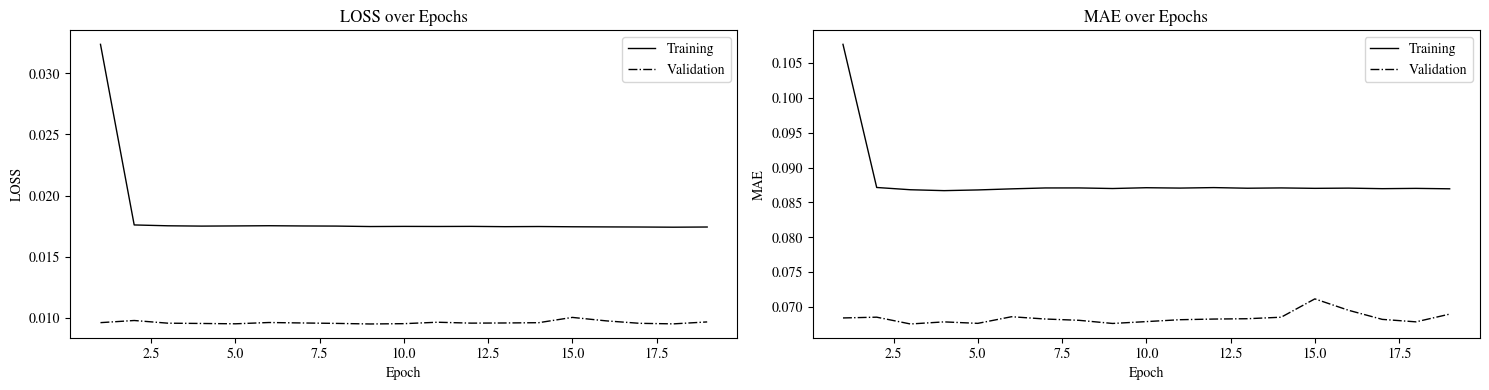

In [ ]:
plot_metrics_side_by_side(ffn_final_history.history, metrics=['loss', 'mae'], figsize=(15, 4))

### **5.2.2 Prediction Tasks**

In [ ]:
validation_evaluation = ffn_final.evaluate(X_val, y_val, verbose=0)
test_evaluation = ffn_final.evaluate(X_test, y_test, verbose=0)

print(f"{'Validation evaluation:':40s} {validation_evaluation}")
print(f"{'Test evaluation:':40s} {test_evaluation}")

1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0080 - mae: 0.0631 - mse: 0.0080
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0088 - mae: 0.0648 - mse: 0.0088
Validation evaluation:                   [0.009499379433691502, 0.009499379433691502, 0.06765437126159668]
Test evaluation:                         [0.010786915197968483, 0.010786915197968483, 0.07184170186519623]


In [ ]:
predict_val_ffn = ffn_final.predict(X_val, batch_size=64)
directional_acc_val_rnn = np.mean(np.multiply(predict_val_ffn, y_val)>0)

predict_test_ffn = ffn_final.predict(X_test, batch_size=64)
directional_acc_test_rnn = np.mean(np.multiply(predict_test_ffn, y_test)>0)

print(f"{'Directional accuracy validation data:':40s} {directional_acc_val_rnn:.7f}")
print(f"{'Directional accuracy test data:':40s} {directional_acc_test_rnn:.7f}")
print(f"{'Directional accuracy difference:':40s} {(directional_acc_test_rnn - directional_acc_val_rnn):.7f}")

528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Directional accuracy validation data:    0.5375096
Directional accuracy test data:          0.5379241
Directional accuracy difference:         0.0004145


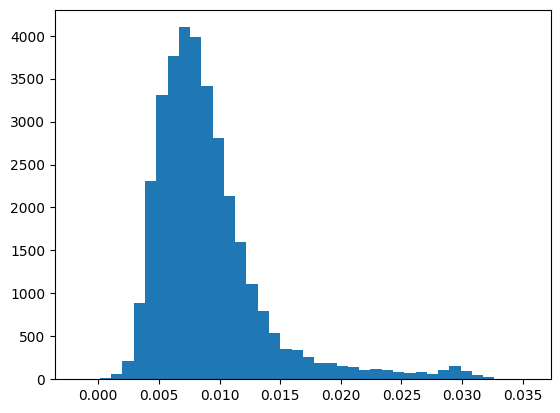

In [ ]:
plt.hist(predict_test_ffn, bins=40)
plt.show()